In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Rescaling                                                  # type: ignore
from tensorflow.keras.models import Sequential                                                                                   # type: ignore
from tensorflow.keras.callbacks import EarlyStopping                                                                             # type: ignore
import matplotlib.pyplot as plt                                                                                                  
import os
import sys
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Python version:", sys.version)
print("CPU Count:", os.cpu_count())

TensorFlow version: 2.20.0
Keras version: 3.11.3
Python version: 3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]
CPU Count: 8


In [39]:
train_another_dir = r'X:\nasim_xhqpjmy\Code\MLops\hurricane-damage\dataset\train_another'
val_dir = r'X:\nasim_xhqpjmy\Code\MLops\hurricane-damage\dataset\validation_another'
test_dir = r'X:\nasim_xhqpjmy\Code\MLops\hurricane-damage\dataset\test'
test_another_dir = r'X:\nasim_xhqpjmy\Code\MLops\hurricane-damage\dataset\test_another'

In [40]:
img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_another_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [41]:
def build_cnn(input_shape=(96, 96, 3)):
    model = Sequential([
        # Normalize & augment 
        Rescaling(1./255, input_shape=input_shape),

        # First conv block
        Conv2D(8, 3, activation='relu', padding='same'),
        MaxPooling2D(),

        #Second conv block 
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPooling2D(),

        # Third conv block — depthwise-separable
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),

        #dense head
        Dense(32, activation='relu'),
        Dropout(0.2),

        #Output
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [42]:
def train_model(train_ds, val_ds, epochs=5):
    model = build_cnn()
    print(model.summary())

    es = EarlyStopping(patience=3, restore_best_weights=True)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[es],
        verbose=1
    )
    return model, history

In [43]:
model, history = train_model(train_ds, val_ds, epochs=5)

x:\nasim_xhqpjmy\Code\MLops\hurricane-damage\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 24, 24, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,169 (12.38 KB)

 Trainable params: 3,169 (12.38 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6083 - loss: 0.6605 - val_accuracy: 0.7885 - val_loss: 0.5429
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8107 - loss: 0.4611 - val_accuracy: 0.8395 - val_loss: 0.3869
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8652 - loss: 0.3635 - val_accuracy: 0.8945 - val_loss: 0.3203
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8827 - loss: 0.3272 - val_accuracy: 0.8740 - val_loss: 0.3184
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8961 - loss: 0.3017 - val_accuracy: 0.9140 - val_loss: 0.2608


In [44]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8980 - loss: 0.2885
Test Accuracy: 89.80%


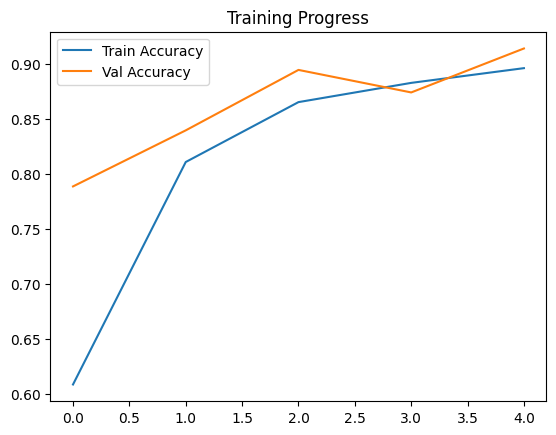

In [45]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training Progress")
plt.show()

In [46]:
model.save("hurricane.h5")